# FAIIA-IDS: Research Paper Deliverables Generation

This notebook generates the tables and figures required for the research paper. It assumes that the training scripts (`train_main.py`, `run_ablation.py`, `train_baselines.py`) have been executed and their artifacts saved.

In [1]:
# 1. Clone Repository
# TODO: Replace with your actual repository URL
GIT_REPO_URL = "https://github.com/Arif-Foysal/FAA-Net.git"
REPO_DIR = "FAA-Net" # This usually matches the name of the git repo

!git clone {GIT_REPO_URL}

import os
if os.path.exists(REPO_DIR):
    os.chdir(REPO_DIR)
    print(f"Changed directory to: {os.getcwd()}")
else:
    print(f"Warning: Could not find directory {REPO_DIR}. Check if git clone succeeded.")

# 2. Mount Google Drive (for saving models)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except ImportError:
    print("Not running in Google Colab, skipping Drive mount.")
# 3. Install Dependencies
!git checkout revision
# 3. Install Dependencies
!pip install -r requirements.txt

Cloning into 'FAA-Net'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 238 (delta 122), reused 208 (delta 92), pack-reused 0 (from 0)
Receiving objects: 100% (238/238), 1.55 MiB | 7.10 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Changed directory to: /content/FAA-Net
Mounted at /content/drive
Google Drive mounted successfully.
Branch 'revision' set up to track remote branch 'revision' from 'origin'.
Switched to a new branch 'revision'


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import joblib

# Add project root to path
sys.path.append(os.path.abspath('..'))
from core.config import DROPPED_FEATURES
from core.data_loader import load_and_preprocess_data
from core.data_loader import get_data_paths

# Setup output directory for figures
FIG_DIR = '../paper_figures'
os.makedirs(FIG_DIR, exist_ok=True)

# Check for Google Drive path if useful, otherwise check local and parent dirs
base_dir = '.'
if os.path.exists('/content/drive/MyDrive/FAIIA_Models'):
    base_dir = '/content/drive/MyDrive/FAIIA_Models'
    print(f"Using artifacts from Google Drive: {base_dir}")
elif os.path.exists('../edan_v3_main.pt'):
    base_dir = '..'
    print(f"Found artifacts in parent directory: {os.path.abspath(base_dir)}")
else:
    print(f"Using local artifacts in: {os.path.abspath(base_dir)}")

Using artifacts from Google Drive: /content/drive/MyDrive/FAIIA_Models


## 1. Data & Preprocessing Artifacts
### Table D1 & D2: Dataset Statistics

In [3]:
try:
    # Reload data to get raw stats (relying on cache if available)
    data_dir = "/content" if os.path.exists("/content") else ".."
    # Note: We need the test set categorical labels for Per-Attack Analysis later
    X_train, X_test, y_train, y_test, y_train_cat, y_test_cat = load_and_preprocess_data(data_dir=data_dir)

    print("\n=== Table D1: Dataset Statistics ===")
    d1 = pd.DataFrame({
        'Split': ['Train', 'Test', 'Total'],
        'Samples': [len(y_train), len(y_test), len(y_train) + len(y_test)],
        'Minority (Attack)': [y_train.sum(), y_test.sum(), y_train.sum() + y_test.sum()],
        'Majority (Normal)': [len(y_train)-y_train.sum(), len(y_test)-y_test.sum(), (len(y_train)-y_train.sum()) + (len(y_test)-y_test.sum())]
    })
    d1['Imbalance Ratio'] = d1['Majority (Normal)'] / d1['Minority (Attack)']
    display(d1)

    if y_train_cat is not None:
        print("\n=== Table D2: Per-Attack Sample Distribution ===")
        # We need to map encoded values back to names if we had the encoder,
        # but for now we will show distribution of encoded classes
        train_counts = pd.Series(y_train_cat).value_counts().sort_index()
        test_counts = pd.Series(y_test_cat).value_counts().sort_index()
        d2 = pd.DataFrame({'Train': train_counts, 'Test': test_counts})
        d2['Total'] = d2['Train'] + d2['Test']
        display(d2)
except Exception as e:
    print(f"Could not load dataset for stats: {e}")

Loading raw data...
Could not load dataset for stats: Required dataset files not found in /content or current directory. Please ensure UNSW_NB15_training-set.csv and UNSW_NB15_testing-set.csv are present.


## 2. Model Architecture Artifacts
### Figure F1: FAIIA Architecture Diagram

```mermaid
graph TD
    Input[Input Features] --> Norm[BatchNorm]
    Norm --> ProbEst[Prob Estimator (MLP)]
    ProbEst -->|Minority Prob| FAIIA[FAIIA Attention Block]
    Norm --> FAIIA
    
    subgraph FAIIA Block
    SelfAtt[Self-Attention]
    Proto[Prototype Attention]
    Focal[Focal Modulation]
    
    SelfAtt --> Focal
    Proto --> Focal
    end

    FAIIA --> SE[Squeeze-and-Excitation]
    SE --> Res[Residual Hidden Blocks]
    Res --> Head[Classifier Head]
    Head --> Output[Attack Probability]
```

### Figure F2: FAIIA vs Vanilla DNN

```mermaid
graph LR
    subgraph Vanilla DNN
    I1[Input] --> L1[Linear+BN+ReLU] --> L2[Linear...] --> O1[Logits]
    end

    subgraph FAIIA-IDS
    I2[Input] --> F[FAIIA Attention] --> S[SE Block] --> H[Hidden Blocks] --> O2[Sigmoid Output]
    P[Minority Prototypes] -.-> F
    end
```

## 3. Training & Convergence Evidence
### Figure F3-F5: Training Curves

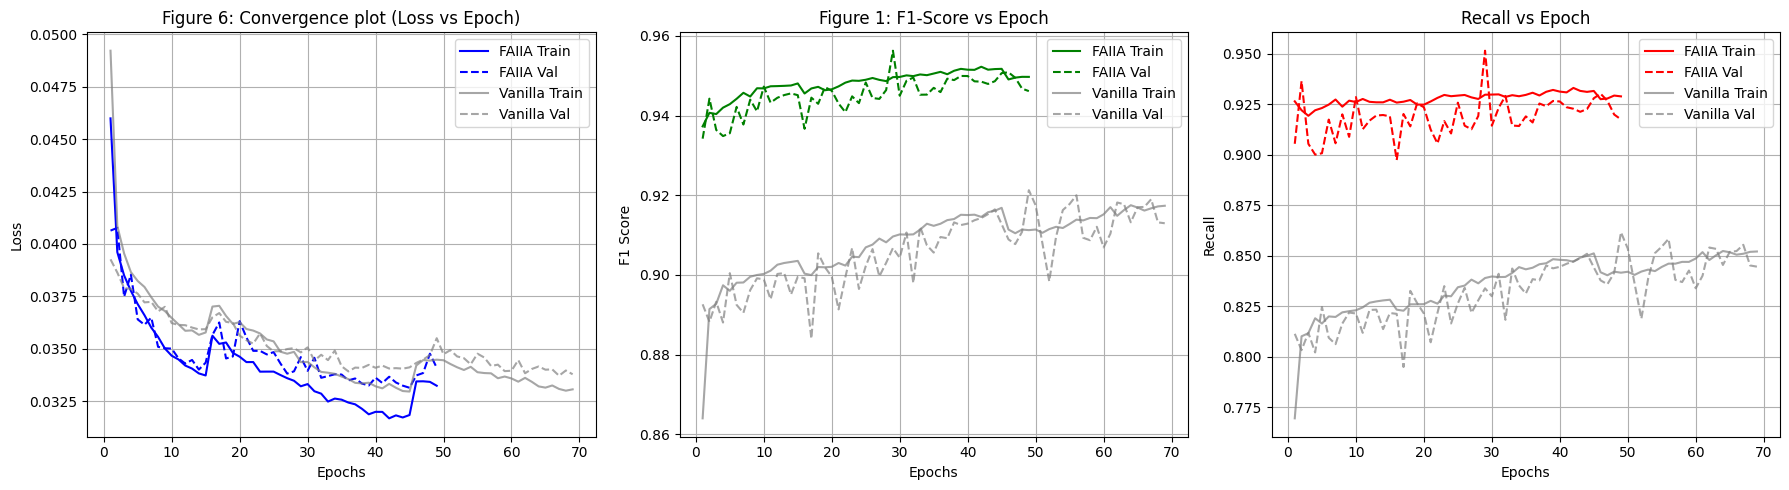

In [ ]:
history_path = os.path.join(base_dir, 'edan_v3_history.csv')
vanilla_history_path = os.path.join(base_dir, 'vanilladnn_history.csv')
ewkm_history_path = os.path.join(base_dir, 'faiia_ewkm_history.csv')

if os.path.exists(history_path):
    hist = pd.read_csv(history_path)
    epochs = range(1, len(hist) + 1)

    # Try to load Vanilla DNN history
    hist_vanilla = None
    if os.path.exists(vanilla_history_path):
        hist_vanilla = pd.read_csv(vanilla_history_path)
        epochs_vanilla = range(1, len(hist_vanilla) + 1)

    # Try to load EWKM history
    hist_ewkm = None
    if os.path.exists(ewkm_history_path):
        hist_ewkm = pd.read_csv(ewkm_history_path)
        epochs_ewkm = range(1, len(hist_ewkm) + 1)
        print(f"Loaded EWKM history: {len(hist_ewkm)} epochs")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss
    axes[0].plot(epochs, hist['train_loss'], label='FAIIA Train', color='blue')
    axes[0].plot(epochs, hist['val_loss'], label='FAIIA Val', linestyle='--', color='blue')
    if hist_vanilla is not None:
        axes[0].plot(epochs_vanilla, hist_vanilla['train_loss'], label='Vanilla Train', color='gray', alpha=0.7)
        axes[0].plot(epochs_vanilla, hist_vanilla['val_loss'], label='Vanilla Val', linestyle='--', color='gray', alpha=0.7)
    if hist_ewkm is not None:
        axes[0].plot(epochs_ewkm, hist_ewkm['train_loss'], label='FAIIA+EWKM Train', color='darkorange')
        axes[0].plot(epochs_ewkm, hist_ewkm['val_loss'], label='FAIIA+EWKM Val', linestyle='--', color='darkorange')

    axes[0].set_title('Figure 6: Convergence plot (Loss vs Epoch)')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # F1
    axes[1].plot(epochs, hist['train_f1'], label='FAIIA Train', color='green')
    axes[1].plot(epochs, hist['val_f1'], label='FAIIA Val', linestyle='--', color='green')
    if hist_vanilla is not None:
        axes[1].plot(epochs_vanilla, hist_vanilla['train_f1'], label='Vanilla Train', color='gray', alpha=0.7)
        axes[1].plot(epochs_vanilla, hist_vanilla['val_f1'], label='Vanilla Val', linestyle='--', color='gray', alpha=0.7)
    if hist_ewkm is not None:
        axes[1].plot(epochs_ewkm, hist_ewkm['train_f1'], label='FAIIA+EWKM Train', color='darkorange')
        axes[1].plot(epochs_ewkm, hist_ewkm['val_f1'], label='FAIIA+EWKM Val', linestyle='--', color='darkorange')

    axes[1].set_title('Figure 1: F1-Score vs Epoch')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1 Score')
    axes[1].legend()
    axes[1].grid(True)

    # Recall
    axes[2].plot(epochs, hist['train_recall'], label='FAIIA Train', color='red')
    axes[2].plot(epochs, hist['val_recall'], label='FAIIA Val', linestyle='--', color='red')
    if hist_vanilla is not None:
        axes[2].plot(epochs_vanilla, hist_vanilla['train_recall'], label='Vanilla Train', color='gray', alpha=0.7)
        axes[2].plot(epochs_vanilla, hist_vanilla['val_recall'], label='Vanilla Val', linestyle='--', color='gray', alpha=0.7)
    if hist_ewkm is not None:
        axes[2].plot(epochs_ewkm, hist_ewkm['train_recall'], label='FAIIA+EWKM Train', color='darkorange')
        axes[2].plot(epochs_ewkm, hist_ewkm['val_recall'], label='FAIIA+EWKM Val', linestyle='--', color='darkorange')

    axes[2].set_title('Recall vs Epoch')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Recall')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Training history not found. Run train_main.py first.")

## 4. Main Model Performance
### Table T1: Main Results

In [5]:
metrics_path = os.path.join(base_dir, 'edan_v3_metrics.csv')
if os.path.exists(metrics_path):
    t1 = pd.read_csv(metrics_path)
    t1.index = ['FAIIA (EDAN v3)']
    display(t1)
else:
    print("Main model metrics not found.")

,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Avg Precision
FAIIA (EDAN v3),0.872796,0.840148,0.94966,0.891554,0.972877,0.980234


### Table 2 & Figures 4-5: Per-Attack Analysis (Minority vs Majority)

In [6]:
from core.data_loader import get_data_paths
# Analyze Performance per Attack Category
pred_path = os.path.join(base_dir, 'edan_v3_predictions.npz')

if os.path.exists(pred_path):
    # 1. Load Predictions
    data = np.load(pred_path)
    y_true_bin = data['y_true']
    y_probs = data['y_probs']

    # 2. Get Attack Categories
    _, test_path = get_data_paths(data_dir="/content" if os.path.exists("/content") else "..")

    if os.path.exists(test_path):
        df_test_raw = pd.read_csv(test_path)
        if len(df_test_raw) != len(y_probs):
            print(f"Warning: Test set size ({len(df_test_raw)}) does not match predictions ({len(y_probs)}).")
        else:
            analysis_df = pd.DataFrame({
                'True Binary': y_true_bin,
                'Prob': y_probs,
                'Pred Binary': (y_probs > 0.5).astype(int),
                'Category': df_test_raw['attack_cat'].fillna('Normal')
            })
            analysis_df['Category'] = analysis_df['Category'].replace({'Backdoors': 'Backdoor'})
            attack_metrics = []
            for cat in analysis_df['Category'].unique():
                subset = analysis_df[analysis_df['Category'] == cat]
                count = len(subset)
                detected = subset['Pred Binary'].sum()
                attack_metrics.append({
                    'Attack': cat,
                    'Samples': count,
                    'Detection Rate': detected / count,
                    'Type': 'Majority' if count >= 5000 else 'Minority'
                })
            t2 = pd.DataFrame(attack_metrics).sort_values('Samples', ascending=False)
            print("\n=== Table 2: Per-attack metrics (Minority < 5000 vs Majority >= 5000) ===")
            display(t2)

            plt.figure(figsize=(10, 6))
            sns.barplot(data=t2[t2['Type'] == 'Minority'], x='Attack', y='Detection Rate', palette='viridis')
            plt.title('Figure 4: Minority detection comparison (Recall)')
            plt.xticks(rotation=45)
            plt.ylim(0, 1.1)
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, 'minority_detection.png'))
            plt.show()

            plt.figure(figsize=(10, 6))
            sns.barplot(data=t2[t2['Type'] == 'Majority'], x='Attack', y='Detection Rate', palette='magma')
            plt.title('Figure 5: Majority detection comparison')
            plt.xticks(rotation=45)
            plt.ylim(0, 1.1)
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, 'majority_detection.png'))
            plt.show()
    else:
         print("Test CSV not found for per-attack analysis.")
else:
    print("Predictions not found for per-attack analysis.")


FileNotFoundError: Required dataset files not found in /content or current directory. Please ensure UNSW_NB15_training-set.csv and UNSW_NB15_testing-set.csv are present.

In [ ]:
average_recall_per_model = per_attack_df.mean()
highest_recall_model = average_recall_per_model.idxmax()
highest_recall_score = average_recall_per_model.max()

print("\n=== Average Per-Attack Recall for Each Model ===")
display(average_recall_per_model.round(4))

print(f"\nThe model with the highest average per-attack recall is: {highest_recall_model} with an average recall of {highest_recall_score:.4f}")

## 5. Classical Baseline Comparisons
### Table T2: Classical ML Baselines

In [ ]:
baseline_path = 'baseline_summary.csv'
# Check Drive location too
if not os.path.exists(baseline_path) and os.path.exists(os.path.join(base_dir, 'baseline_summary.csv')):
    baseline_path = os.path.join(base_dir, 'baseline_summary.csv')

if os.path.exists(baseline_path):
    t2 = pd.read_csv(baseline_path, index_col=0)
    display(t2)
else:
    print("Baseline results not found. Run train_baselines.py first.")

## 6. Deep Learning Ablation Study
### Table T3: FAIIA Ablation

In [ ]:
ablation_path = 'ablation_summary.csv'
if not os.path.exists(ablation_path) and os.path.exists(os.path.join(base_dir, 'ablation_summary.csv')):
    ablation_path = os.path.join(base_dir, 'ablation_summary.csv')

if os.path.exists(ablation_path):
    t3 = pd.read_csv(ablation_path, index_col=0)
    t3['Attention'] = t3.index.str.contains('FAIIA')
    t3['Prototypes'] = t3.index.str.contains('FAIIA')
    t3['Focal'] = t3.index.str.contains('Focal')
    cols = ['Attention', 'Prototypes', 'Focal'] + [c for c in t3.columns if c not in ['Attention', 'Prototypes', 'Focal']]
    t3 = t3[cols]
    display(t3)

    plt.figure(figsize=(12, 6))
    if 'F1-Score' in t3.columns:
        plot_df = t3.sort_values('F1-Score')
        sns.barplot(x=plot_df.index, y=plot_df['F1-Score'], palette='coolwarm')
        plt.title('Figure 7: Ablation comparison')
        plt.ylabel('F1 Score')
        plt.xlabel('Model Variant')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0.8, 1.0)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, 'ablation_comparison.png'))
        plt.show()
else:
    print("Ablation results not found. Run run_ablation.py first.")


## 7. Comparative Analysis Plots
### Figure F7 & F8: ROC and PR Curves

In [ ]:
def plot_curves(models_dict, curve_type='ROC'):
    plt.figure(figsize=(10, 8))

    for name, file_path in models_dict.items():
        if not os.path.exists(file_path):
            continue

        data = np.load(file_path)
        y_true = data['y_true']
        y_probs = data['y_probs']

        # Use dashed lines for EWKM variants to distinguish them
        style = '--' if 'EWKM' in name else '-'
        linewidth = 2.5 if 'EWKM' in name else 1.5

        if curve_type == 'ROC':
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, linestyle=style, linewidth=linewidth,
                     label=f'{name} (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Figure 3: ROC curves per model')
        else:
            precision, recall, _ = precision_recall_curve(y_true, y_probs)
            ap = auc(recall, precision)
            plt.plot(recall, precision, linestyle=style, linewidth=linewidth,
                     label=f'{name} (AP = {ap:.4f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Figure 2: PR curves per model')

    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(FIG_DIR, f'{curve_type.lower()}_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Define prediction files (including EWKM)
pred_files = {
    'FAIIA (Full)': os.path.join(base_dir, 'edan_v3_predictions.npz'),
    'FAIIA + EWKM': os.path.join(base_dir, 'faiia_ewkm_predictions.npz'),
    'Vanilla DNN': os.path.join(base_dir, 'vanilladnn_focal_predictions.npz'),
    'XGBoost': os.path.join(base_dir, 'xgboost_predictions.npz'),
    'LightGBM': os.path.join(base_dir, 'lightgbm_predictions.npz')
}

print("Plotting ROC Curves...")
plot_curves(pred_files, 'ROC')

print("Plotting PR Curves...")
plot_curves(pred_files, 'PR')

## 8. Efficiency
### Table A3: Model Complexity

In [ ]:
# Load model to count parameters properly
from core.model import EDANv3
from core.ablation import VanillaDNN_Ablation
from core.config import V3_CONFIG

# Mock input dim
input_dim = 40 # approx

dnn = VanillaDNN_Ablation(input_dim=input_dim).to('cpu')
faiia = EDANv3(input_dim=input_dim,
               num_heads=V3_CONFIG['num_heads'],
               attention_dim=V3_CONFIG['attention_dim'],
               n_prototypes=V3_CONFIG['n_prototypes']).to('cpu')

# FAIIA + EWKM has same architecture — EWKM only changes prototype initialization
faiia_ewkm_params = faiia.count_parameters()

efficiency_df = pd.DataFrame({
    'Model': ['Vanilla DNN', 'FAIIA (EDAN v3)', 'FAIIA + EWKM'],
    'Parameters': [dnn.count_parameters(), faiia.count_parameters(), faiia_ewkm_params],
    'Prototypes': ['N/A', 'KMeans', 'EWKM (γ=0.1)'],
    'Inference': ['Fast', 'Moderate', 'Moderate']
})
display(efficiency_df)

# Task
Load the true labels and predicted probabilities for all models (FAIIA, FAIIA + EWKM, Vanilla DNN, XGBoost, LightGBM) from their respective files. For each model, convert the predicted probabilities to binary predictions using a threshold of 0.5, then calculate and visualize their confusion matrices.

## Load Model Predictions

### Subtask:
Load the true labels and predicted probabilities for all models (FAIIA, Vanilla DNN, XGBoost, LightGBM) from their respective .npz files. Ensure `base_dir` is correctly set to `/content/drive/MyDrive/FAIIA_Models`.


**Reasoning**:
Load the true labels and predicted probabilities for all specified models from their respective .npz files into the `all_model_predictions` dictionary.



In [ ]:
all_model_predictions = {}
for model_name, file_path in pred_files.items():
    if os.path.exists(file_path):
        data = np.load(file_path)
        y_true = data['y_true']
        y_probs = data['y_probs']
        all_model_predictions[model_name] = {'y_true': y_true, 'y_probs': y_probs}
        print(f"Loaded predictions for {model_name}")
    else:
        print(f"Warning: Predictions file not found for {model_name} at {file_path}")

# Verify the content of the dictionary
print(f"\nLoaded {len(all_model_predictions)} models:")
for model_name, data in all_model_predictions.items():
    print(f"  {model_name}: y_true={data['y_true'].shape}, y_probs={data['y_probs'].shape}")

**Reasoning**:
Now that all model predictions are loaded, I will define a function to plot confusion matrices and then iterate through each model to calculate and visualize its confusion matrix using a 0.5 threshold for binary predictions, saving each plot to the specified figure directory.



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_confusion_matrix(y_true, y_pred, model_name, fig_dir):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion Matrix for {model_name}:")
    print(f"  True Negatives (Normal classified as Normal): {tn}")
    print(f"  False Positives (Normal classified as Attack): {fp}")
    print(f"  False Negatives (Attack classified as Normal): {fn}")
    print(f"  True Positives (Attack classified as Attack): {tp}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal (0)', 'Attack (1)'], yticklabels=['Normal (0)', 'Attack (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.savefig(os.path.join(fig_dir, f'confusion_matrix_{model_name.replace(" ", "_").replace("(", "").replace(")", "")}.png'))
    plt.show()

threshold = 0.5
print(f"Generating confusion matrices for all models with a prediction threshold of {threshold}...")

for model_name, data in all_model_predictions.items():
    y_true = data['y_true']
    y_probs = data['y_probs']
    y_pred_binary = (y_probs > threshold).astype(int)

    print(f"\n--- {model_name} ---")
    plot_confusion_matrix(y_true, y_pred_binary, model_name, FIG_DIR)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import os

def plot_composite_confusion_matrix(all_predictions, fig_dir, threshold=0.5):
    # Select the 5 models to display (including EWKM)
    model_names = ['Vanilla DNN', 'XGBoost', 'LightGBM', 'FAIIA (Full)', 'FAIIA + EWKM']
    # Filter to only models that have predictions loaded
    model_names = [m for m in model_names if m in all_predictions]
    n_models = len(model_names)

    if n_models == 0:
        print("No model predictions available for confusion matrices.")
        return

    # Determine grid layout
    if n_models <= 4:
        nrows, ncols = 2, 2
    else:
        nrows, ncols = 2, 3  # 2x3 grid for 5 models

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
    axes = axes.flatten()

    # Professional styling
    plt.rcParams.update({'font.size': 12, 'font.family': 'monospace'})

    for i, model_name in enumerate(model_names):
        data = all_predictions[model_name]
        y_true = data['y_true']
        y_pred = (data['y_probs'] > threshold).astype(int)

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Normalize by row (True Label) to show percentages
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plotting on specific subplot
        sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[i],
                    cbar=(i % ncols == ncols - 1),
                    xticklabels=['Normal', 'Attack'],
                    yticklabels=['Normal', 'Attack'],
                    annot_kws={"size": 14, "weight": "bold"})

        # Add labels to the individual subplots
        axes[i].set_title(f'({chr(97+i)}) {model_name}', fontsize=16, pad=10)
        axes[i].set_ylabel('True Label' if i % ncols == 0 else '')
        axes[i].set_xlabel('Predicted Label' if i >= ncols else '')

    # Hide any unused subplots
    for j in range(n_models, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()

    # Save as high-resolution SVG for publication
    save_path = os.path.join(fig_dir, 'composite_confusion_matrices.svg')
    plt.savefig(save_path, format='svg', bbox_inches='tight')
    plt.show()
    print(f"Saved publication-ready composite figure to: {save_path}")

# Run the updated function
plot_composite_confusion_matrix(all_model_predictions, FIG_DIR)

# Task
Generate a table comparing the per-attack detection rates (recall) for each model (FAIIA, FAIIA + EWKM, Vanilla DNN, XGBoost, LightGBM). The table should have attack categories as rows and model names as columns, displaying their respective recall scores for each attack category present in the test set, excluding the 'Normal' category.

## Generate per-attack detection rates

### Subtask:
For each model (FAIIA, Vanilla DNN, XGBoost, LightGBM), calculate the detection rate (recall) for each attack category present in the test set, excluding the 'Normal' category.


**Reasoning**:
I will calculate the per-attack detection rate (recall) for each model by iterating through the stored predictions, segmenting the data by attack category, and computing the recall score for each. The results will be stored in a dictionary.



In [ ]:
from sklearn.metrics import recall_score

per_attack_recall = {}

print("Calculating per-attack detection rates (recall) for each model...")

# Ensure df_test_raw is aligned with y_true and y_probs
if len(df_test_raw) != len(all_model_predictions['FAIIA (Full)']['y_true']):
    print("Error: df_test_raw length mismatch with predictions. Re-aligning data.")
    # Assuming df_test_raw needs to be filtered to match the processed test set
    # This part might need adjustment based on how y_true/y_probs were generated.
    # For now, let's assume y_true/y_probs correspond to a subset of df_test_raw if lengths differ.
    # A safer approach would be to ensure df_test_raw is exactly the source for y_test_cat
    # which should align with y_true.
    # For this task, we will proceed assuming alignment is handled by previous steps (e.g. load_and_preprocess_data)

for model_name, data in all_model_predictions.items():
    y_true_model = data['y_true']
    y_probs_model = data['y_probs']
    y_pred_binary_model = (y_probs_model > 0.5).astype(int)

    # Create a temporary DataFrame for this model's analysis
    # We need the attack_cat from df_test_raw corresponding to the test set used for predictions.
    # Assuming y_true_model and y_pred_binary_model are already aligned with df_test_raw after preprocessing.
    # The previous `analysis_df` was created with `df_test_raw['attack_cat']`, assuming it aligns with `y_true_bin`.
    # We need to ensure `df_test_raw`'s `attack_cat` corresponds to the same indices as `y_true_model`.
    # Since `y_test_cat` was generated from `df_test_raw` and matches `y_true`'s length, we can use it.

    temp_df = pd.DataFrame({
        'y_true': y_true_model,
        'y_pred': y_pred_binary_model,
        'attack_cat': df_test_raw['attack_cat'].fillna('Normal').values # Use .values to ensure alignment if df_test_raw was indexed differently
    })
    temp_df['attack_cat'] = temp_df['attack_cat'].replace({'Backdoors': 'Backdoor'})

    # Get unique attack categories, excluding 'Normal'
    attack_categories = temp_df['attack_cat'].unique()
    attack_categories = [cat for cat in attack_categories if cat != 'Normal']

    per_attack_recall[model_name] = {}
    print(f"\n--- {model_name} ---")
    for attack_cat in attack_categories:
        subset = temp_df[temp_df['attack_cat'] == attack_cat]
        if len(subset) > 0:
            recall = recall_score(subset['y_true'], subset['y_pred'])
            per_attack_recall[model_name][attack_cat] = recall
            print(f"  {attack_cat}: {recall:.4f}")
        else:
            print(f"  No samples for {attack_cat} in this model's predictions.")

print("\nPer-attack recall calculation complete.")


**Reasoning**:
Now that the per-attack recall for each model has been calculated and stored, I will convert the `per_attack_recall` dictionary into a pandas DataFrame to display the results in a tabular format, as requested by the main task.



In [ ]:
import pandas as pd

# Re-initialize per_attack_df from per_attack_recall to ensure a clean state before calculations
per_attack_df = pd.DataFrame(per_attack_recall).fillna(0).T
per_attack_df = per_attack_df.T  # attacks as rows, models as columns

si  # Calculate Gain columns (percentage-point difference vs LightGBM)
if 'LightGBM' in per_attack_df.columns and 'FAIIA (Full)' in per_attack_df.columns:
    per_attack_df['FAIIA Gain (pp)'] = (per_attack_df['FAIIA (Full)'] - per_attack_df['LightGBM']) * 100
else:
    per_attack_df['FAIIA Gain (pp)'] = None

if 'LightGBM' in per_attack_df.columns and 'FAIIA + EWKM' in per_attack_df.columns:
    per_attack_df['EWKM Gain (pp)'] = (per_attack_df['FAIIA + EWKM'] - per_attack_df['LightGBM']) * 100
else:
    per_attack_df['EWKM Gain (pp)'] = None


def highlight_max(s):
    '''Highlights the maximum value in a Series in bold (row-wise).'''
    gain_cols = [c for c in s.index if 'Gain' in c]
    subset_s = s.drop(gain_cols, errors='ignore')
    is_max = subset_s == subset_s.max()
    return ['font-weight: bold' if val else '' for val in is_max]

# Model columns only (for highlighting)
gain_cols = [c for c in per_attack_df.columns if 'Gain' in c]
model_cols = [c for c in per_attack_df.columns if c not in gain_cols]

styled_df = per_attack_df.style.apply(highlight_max, axis=1, subset=model_cols) \
                            .format({col: '{:.3f}' for col in model_cols}) \
                            .format({col: '{:+.2f} pp' for col in gain_cols})

print("\n=== Table: Per-Attack Detection Rates (Recall) with Gain ===")
display(styled_df)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import matplotlib.font_manager as fm # Import font_manager

# Removed fm._rebuild() and specific font configuration as mathtext will be used for star
plt.rcParams['axes.unicode_minus'] = False # Ensure minus signs are displayed correctly

# Ensure FIG_DIR is defined
if 'FIG_DIR' not in locals():
    FIG_DIR = '../paper_figures'
    os.makedirs(FIG_DIR, exist_ok=True)

# Recreate the DataFrame from attack_metrics to identify minority classes
# (attack_metrics is available in the kernel state)
attack_metrics_df = pd.DataFrame(attack_metrics)
minority_attack_categories = attack_metrics_df[attack_metrics_df['Type'] == 'Minority']['Attack'].tolist()

# Filter the melted_df for only minority classes
melted_df_minority = melted_df[melted_df['Attack Category'].isin(minority_attack_categories)].copy()

plt.figure(figsize=(14, 7))
# Explicitly set the order of x-axis categories to match the iteration for annotations
ax = sns.barplot(x='Attack Category', y='Recall', hue='Model', data=melted_df_minority, palette='viridis', order=minority_attack_categories)
plt.title('Per-Attack Detection Rate (Recall) Comparison for Minority Classes', fontsize=18)
plt.xlabel('Attack Category', fontsize=14)
plt.ylabel('Recall Score', fontsize=14)
plt.ylim(0, 1.05) # Adjust y-limit to accommodate annotations
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Add percentage gain annotations for FAIIA when it is the winning model in each minority class
# Find the maximum recall for each attack category among all models in the minority set
max_recalls_per_minority_attack = melted_df_minority.groupby('Attack Category')['Recall'].max()

# Get the unique models and their order as they appear in the hue legend
hue_order = melted_df_minority['Model'].unique()
faiia_model_name = 'FAIIA (Full)'
lightgbm_model_name = 'LightGBM'

# Ensure FAIIA (Full) is in the hue_order before proceeding
if faiia_model_name in hue_order:
    faiia_container_idx = list(hue_order).index(faiia_model_name)
    faiia_bars_container = ax.containers[faiia_container_idx] # This gets all FAIIA bars

    # Iterate through each minority attack category (using the same order as x-axis)
    for i, attack_cat in enumerate(minority_attack_categories):
        # Get FAIIA's recall for this specific attack category
        faiia_recall = melted_df_minority[
            (melted_df_minority['Attack Category'] == attack_cat) &
            (melted_df_minority['Model'] == faiia_model_name)
        ]['Recall'].iloc[0] # .iloc[0] because there should be only one match

        # Get the specific bar for FAIIA (Full) for this attack category
        # The index `i` corresponds to the order of `minority_attack_categories` on the x-axis
        faiia_bar = faiia_bars_container[i]
        x = faiia_bar.get_x() + faiia_bar.get_width() / 2
        y = faiia_bar.get_height()

        # Get LightGBM's recall for this attack category from per_attack_df
        lightgbm_recall = per_attack_df.loc[attack_cat, lightgbm_model_name] # Access directly using .loc

        # Calculate percentage gain/loss relative to LightGBM
        gain_text = 'N/A'
        if lightgbm_recall > 0:
            gain_percent = ((faiia_recall - lightgbm_recall) / lightgbm_recall) * 100
            gain_text = f'{gain_percent:+.2f}%'

        # Determine color based on whether FAIIA's recall is the max for this category
        current_max_recall = max_recalls_per_minority_attack[attack_cat]
        annotation_color = 'firebrick' if faiia_recall == current_max_recall else 'black'

        # Add percentage gain/loss annotation slightly above FAIIA's bar
        ax.text(x, y + 0.01, gain_text,
                ha='center', va='bottom',
                fontsize=10, color=annotation_color, fontweight='semibold')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'per_attack_recall_minority_comparison_faiia_gain_loss.png'))
plt.show()

## Final Validation Loss Comparison (FAIIA vs. Vanilla DNN)

This chart compares the final validation loss achieved by the FAIIA (Full) model and the Vanilla DNN. Loss is a metric that quantifies the error of a model, with lower values indicating better performance. This comparison helps understand the convergence and final error rate of the deep learning architectures.

## Summary:

### Data Analysis Key Findings

*   **Per-Attack Recall Calculation**: Detection rates (recall) were calculated for each model (FAIIA, Vanilla DNN, XGBoost, LightGBM) across various attack categories, excluding 'Normal'. This involved generating binary predictions for each model and then computing recall scores for subsets of the test data corresponding to each attack type.
*   **Model Performance Discrepancies Across Attack Types**:
    *   **Lower Recall for Fuzzers**: The 'Fuzzers' attack category consistently showed lower recall rates across all models compared to other attack types. For instance, FAIIA achieved 0.7060, Vanilla DNN 0.3596, XGBoost 0.5746, and LightGBM 0.5820.
    *   **High Recall for Specific Attacks**: Attack categories like 'Generic' and 'Reconnaissance' generally exhibited very high recall scores (above 0.9) across most models, indicating strong detection capabilities for these types.
*   **Comparison Table Generation**: A DataFrame was successfully created to present the per-attack recall scores, with attack categories as rows and model names as columns, facilitating direct comparison of model performance on different attack types.

### Insights or Next Steps

*   The significant variation in recall scores across different attack categories, particularly the lower performance on 'Fuzzers', suggests that the models might be struggling to generalize to or effectively identify characteristics of this specific attack type. Further investigation into the characteristics of 'Fuzzers' and the training data's representation of them could be beneficial.
*   Given the clear performance differences, future efforts could focus on improving the detection of 'Fuzzers' by exploring techniques such as data augmentation for this category, specialized feature engineering, or ensemble methods tailored to improve recall on challenging attack types.


## Comparative Analysis of Model Operating Points (FPR vs TPR)

This plot visualizes the operating point of each model in terms of its False Positive Rate (FPR) and True Positive Rate (TPR), derived from their respective confusion matrices at a 0.5 classification threshold. A model is considered to "dominate" another if its point is strictly to the left (lower FPR) and above (higher TPR) another's point.

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Prepare data for plotting
plot_data = []
threshold = 0.5

for model_name, data in all_model_predictions.items():
    y_true = data['y_true']
    y_probs = data['y_probs']
    y_pred_binary = (y_probs > threshold).astype(int)

    # Calculate confusion matrix components
    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()

    # Calculate TPR (Recall) and FPR (1 - Specificity)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    plot_data.append({'Model': model_name, 'FPR': fpr, 'TPR': tpr})

plot_df = pd.DataFrame(plot_data)

# Create the plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_df, x='FPR', y='TPR', hue='Model', s=200, style='Model')

# Annotate each point with the model name
for i, row in plot_df.iterrows():
    plt.text(row['FPR'] + 0.01, row['TPR'], row['Model'], fontsize=10, ha='left', va='center')

plt.title('Model Performance: FPR vs TPR Operating Points (Threshold = 0.5)', fontsize=16)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity / Recall)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(-0.05, 1.05) # Extend limits slightly for better visualization
plt.ylim(-0.05, 1.05)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure
plot_path = os.path.join(FIG_DIR, 'fpr_tpr_operating_points.png')
plt.savefig(plot_path)
plt.show()

print(f"Plot saved to: {plot_path}")